In [1]:
import os
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Layer, Multiply,GlobalAveragePooling1D,MultiHeadAttention,Embedding,Lambda,Dense,Flatten,Conv2D,Dropout, Conv2DTranspose, MaxPooling2D, Input, Activation, 
    Concatenate, UpSampling2D, Resizing,Reshape,Add,LayerNormalization,BatchNormalization
)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.initializers import TruncatedNormal
from einops import rearrange
import pickle
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import albumentations as A
import time

In [2]:
path = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset'

In [3]:
data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 6000, shuffle = False)

Found 5682 files belonging to 2 classes.


In [4]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(5682, 128, 128, 3) (5682,)


In [5]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(2841, 128, 128, 3) (2841, 128, 128, 3)


In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, masks, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(2272, 128, 128, 3) (569, 128, 128, 3)


In [7]:
# Convert masks to single channel (binary)
y_train = (y_train[..., 0] > 0).astype("uint8")  # Assuming the first channel represents the mask
y_test = (y_test[..., 0] > 0).astype("uint8")
print(y_train.shape, y_test.shape)
# Reshape your target arrays to match the model's output shape
y_train = y_train.reshape((-1, 128, 128, 1))
y_test = y_test.reshape((-1, 128, 128, 1))

print(y_train.shape, y_test.shape)

(2272, 128, 128) (569, 128, 128)
(2272, 128, 128, 1) (569, 128, 128, 1)


In [8]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
])

def augment_image(img, mask):
    augmented = transform(image=img, mask=mask)
    return augmented['image'], augmented['mask']

X_aug, y_aug = zip(*[augment_image(img, mask) for img, mask in zip(X_train, y_train)])

X_train = np.concatenate((X_train, np.array(X_aug)), axis=0)
y_train = np.concatenate((y_train, np.array(y_aug)), axis=0)

In [9]:
print(f"X_train: {X_train.shape} and y_train: {y_train.shape}")

X_train: (4544, 128, 128, 3) and y_train: (4544, 128, 128, 1)


In [10]:
def plot_images(X_test, y_test, model_mask, selected_indices):
    for i in selected_indices:
        plt.figure(figsize=(15,5))

        # orignal image
        plt.subplot(1,4,1)
        plt.imshow(X_test[i].squeeze())
        plt.title("Orignal Image")
        plt.axis("off")

        # Orignal Mask
        plt.subplot(1,4,2)
        plt.imshow(y_test[i].squeeze(), cmap='viridis')
        plt.title('Orignal Mask')
        plt.axis("off")

        # Model Mask
        plt.subplot(1,4,3)
        plt.imshow(model_mask[i].squeeze(), cmap='viridis')
        plt.title('Model Mask')
        plt.axis("off")
    plt.show()

In [11]:
def plot_training_history(history, title):
    # Check if `history` is a dictionary and adapt
    if isinstance(history, dict):
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt

In [12]:
def calculate_IOU(y_true, y_pred, threshold = 0.5):
    y_pred = (y_pred > threshold).astype(np.uint8) # Binarize predictions
    intersection = np.sum(y_true * y_pred, axis = (1,2)) # Per image
    union = np.sum(y_true + y_pred, axis = (1,2)) - intersection # Per image
    iou = np.mean(intersection / (union + 1e-6)) # Avoid division by zero
    return iou

def Training_IoU(model, X_train, y_train):
    train_predictions = model.predict(X_train)
    train_predictions = train_predictions.squeeze()  # Shape:(height, width)
    y_train = y_train.squeeze()  # Shape:, height, width)

    train_iou = calculate_IOU(y_train, train_predictions)
    return train_iou

def Testing_IoU (model, X_test, y_test):
    test_predictions = model.predict(X_test)
    test_predictions = test_predictions.squeeze()  # Shape: ( height, width)
    y_test = y_test.squeeze()  # Shape: (batch_size, height, width)

    test_iou = calculate_IOU(y_test, test_predictions)
    return test_iou

In [15]:
def evaluation(model, model_name):
    #results_train = model.evaluate(X_train, y_train, verbose=0)
    #results_test = model.evaluate(X_test, y_test, verbose=0)

    #train_loss, train_accuracy = results_train[0], results_train[1]
    #test_loss, test_accuracy = results_test[0], results_test[1]

    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    data = {
    'Algorithm': [model_name[0], model_name[1]],
    'Accuracy': [f"{train_accuracy:.3f}", f"{test_accuracy:.3f}"],
    'Loss': [f"{train_loss:.3f}", f"{test_loss:.3f}"],
    'mIOU': [f"{Training_IoU(model, X_train, y_train):.3f}", f"{Testing_IoU(model, X_test, y_test):.3f}"]
    }

    df = pd.DataFrame(data)

    return df

In [37]:
config = {}
config["image_size"] = 128
config["num_channels"] = 3
config["num_layers"] = 12
config["hidden_dim"] = 512
config["mlp_dim"] = 3072
config["num_heads"] = 12
config["dropout_rate"] = 0.1
#config["num_patches"] = 256
config["patch_size"] = 16
config["num_patches"] = (config["image_size"]**2) // (config["patch_size"]**2)
print(config["num_patches"])

64


In [16]:
@keras.saving.register_keras_serializable()
class Create_Patches(Layer):
    def __init__(self, patch_size, channels=3, **kwargs):
        super(Create_Patches, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.channels = channels
        # Use a Conv2D layer with filters = window_size * window_size * channels
        self.conv = Conv2D(
            filters=patch_size * patch_size * channels,  # Number of patch features
            kernel_size=patch_size,
            strides=patch_size,
            padding="valid",
        )

    def call(self, images):
        # Apply convolution to extract patches
        patches = self.conv(images)
        shape = tf.shape(patches)
        B, H, W, C = shape[0], shape[1], shape[2], shape[3]
        #B, H, W, C = tf.shape(patches)
        # Reshape to [B, H*W, C] where C = window_size * window_size * channels
        patches = tf.reshape(patches, [B, H * W, C])
        return patches

    def compute_output_shape(self, input_shape):
        B, H, W, C = input_shape
        # Calculate new height and width after convolution
        new_H = H // self.patch_size
        new_W = W // self.patch_size
        # Output shape is [B, new_H * new_W, window_size * window_size * channels]
        return (B, new_H * new_W, self.patch_size * self.patch_size * self.channels)

In [17]:
#X_train = tf.cast(X_train, tf.float32)
batch = tf.cast(X_train, tf.float32)
patches = Create_Patches(config["patch_size"])(batch[:32])
patches.shape

TensorShape([32, 64, 768])

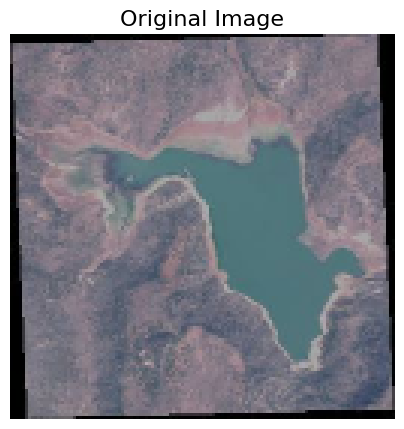

In [18]:
plt.figure(figsize=(5, 5))
plt.imshow(X_train[0].astype("uint8"))
plt.title("Original Image", fontsize=16)
plt.axis("off")
plt.show()

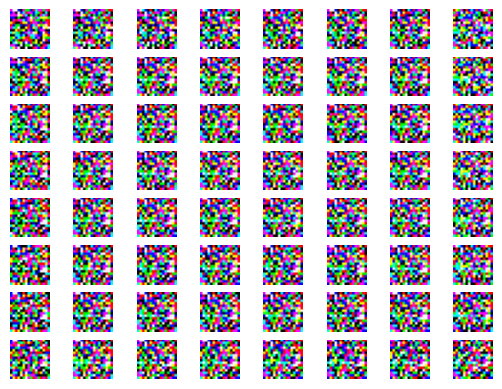

In [19]:
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (config["patch_size"], config["patch_size"], 3))
    ax.imshow(patch_img.numpy().astype("uint8"))
    ax.axis("off")

In [17]:
@keras.saving.register_keras_serializable()
class LinearEmbedding(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(LinearEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [21]:
data = (patches.shape[1], patches.shape[2])
print(data)
embeddings = LinearEmbedding(config["num_patches"], config["hidden_dim"])(patches[:32])
embeddings.shape

(64, 768)


TensorShape([32, 64, 768])

In [18]:
@keras.saving.register_keras_serializable()
class MLP(Layer):
    def __init__(self, mlp_dim, hidden_dim, dropout_rate=0.1, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.dense1 = Dense(mlp_dim, activation=tf.nn.gelu)
        self.dense2 = Dense(hidden_dim)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [23]:
mlp = MLP(config["mlp_dim"],config["hidden_dim"])(patches[:32])
mlp.shape

TensorShape([32, 64, 768])

In [35]:
@keras.saving.register_keras_serializable()
class TransformerEncoder(Layer):
    def __init__(self, num_heads, hidden_dim, mlp_dim, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim

        self.layer_norm1 = LayerNormalization()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)
        self.add1 = Add()

        self.layer_norm2 = LayerNormalization()
        self.mlp = MLP(config["mlp_dim"],config["hidden_dim"])
        self.add2 = Add()

    def call(self, inputs):
        # First sub-layer: Multi-Head Self-Attention
        skip1 = inputs
        x = self.layer_norm1(inputs)
        x = self.mha(x, x)
        x = self.add1([x, skip1])

        # Second sub-layer: Feed Forward Network (MLP)
        skip2 = x
        x = self.layer_norm2(x)
        x = self.mlp(x)
        x = self.add2([x, skip2])

        return x

In [25]:
x = TransformerEncoder(config["num_heads"], config["hidden_dim"], config["mlp_dim"])(embeddings[:32])
print(x.shape)

(32, 64, 768)


In [38]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [39]:
def deconv_block(x, num_filters):
    x = Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

In [40]:
def ViT_UNET(input_shape=(128, 128, 3), cf = config):
    inputs = Input(input_shape)

    patches = Create_Patches(cf["patch_size"])(inputs)

    x = LinearEmbedding(cf["num_patches"], cf["hidden_dim"])(patches)

    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"] + 1, 1):
        x = TransformerEncoder(config["num_heads"], config["hidden_dim"], config["mlp_dim"])(x)

        if i in skip_connection_index:
            skip_connections.append(x)

    z3, z6, z9, z12 = skip_connections
    #print(z3.shape, z6.shape, z9.shape, z12.shape)

    z0 = Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)

    # Compute height and width of feature maps
    patch_grid_size = int(np.sqrt(cf["num_patches"]))   # Assuming square patches
    feature_channels = cf["hidden_dim"]
    z3 = Reshape((-1, feature_channels))(z3)  # Flattened shape
    z6 = Reshape((-1, feature_channels))(z6)
    z9 = Reshape((-1, feature_channels))(z9)
    z12 = Reshape((-1, feature_channels))(z12)


    z3 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z3)
    z6 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z6)
    z9 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z9)
    z12 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z12)
    print(z0.shape, z3.shape, z6.shape, z9.shape, z12.shape)

    ## Decoder 1
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)
    x = Concatenate()([x, s])

    x = conv_block(x, 512)
    x = conv_block(x, 512)

    ## Decoder 2
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    s = deconv_block(s, 256)
    s = conv_block(s, 256)

    x = Concatenate()([x, s])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    ## Decoder 3
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 4
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    outputs = Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)
    return Model(inputs, outputs, name="UNETR_2D")

In [41]:
model = ViT_UNET()
#model.summary()

(None, 128, 128, 3) (None, 8, 8, 512) (None, 8, 8, 512) (None, 8, 8, 512) (None, 8, 8, 512)


In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # clipvalue=0.5
    loss= "binary_crossentropy",
    metrics=["accuracy"]  # Include both IoU and Dice metrics
)

In [43]:
# Early Stopping
c1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

In [44]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

In [27]:
checkpoint_callback = ModelCheckpoint(
    filepath='vit_unet.keras',
    save_best_only=True,
    monitor='val_loss',  # You can adjust this to the desired metric
    mode='min',          # Use 'min' for loss and 'max' for accuracy
    verbose=1
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size = 20,
    callbacks = [lr_scheduler, c1]
)

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 243s 688ms/step - accuracy: 0.7339 - loss: 0.5436 - val_accuracy: 0.4322 - val_loss: 3.3591 - learning_rate: 0.0010
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 108s 473ms/step - accuracy: 0.7766 - loss: 0.4792 - val_accuracy: 0.6136 - val_loss: 0.7970 - learning_rate: 0.0010
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 108s 473ms/step - accuracy: 0.8021 - loss: 0.4397 - val_accuracy: 0.8027 - val_loss: 0.4337 - learning_rate: 0.0010
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 107s 470ms/step - accuracy: 0.8163 - loss: 0.4120 - val_accuracy: 0.5587 - val_loss: 0.6783 - learning_rate: 0.0010
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 107s 470ms/step - accuracy: 0.8233 - loss: 0.3984 - val_accuracy: 0.8070 - val_loss: 0.4399 - learning_rate: 0.0010
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 107s 471ms/step - accuracy: 0.8153 - loss: 0.4107 - val_accuracy: 0.8105 - val_loss: 0.4352 - learning_rate: 0.0010
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 107s 471ms/step -

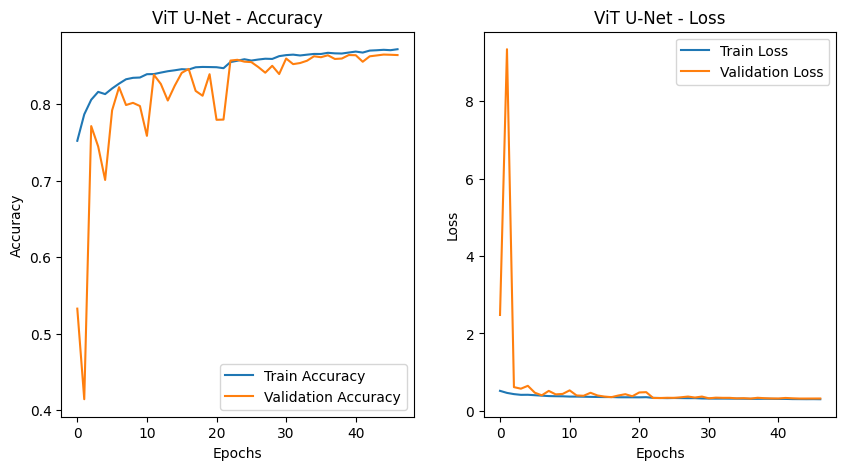

In [29]:
plot_training_history(history, "ViT U-Net")

In [30]:
with open('/kaggle/working/vit_unet_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
model.save("vit_unet.keras")

In [31]:
model_matrix = evaluation(model, ['ViT_Unet (Training)', 'ViT_Unet (Validation)'])
print(model_matrix)

142/142 ━━━━━━━━━━━━━━━━━━━━ 50s 326ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 574ms/step
               Algorithm Accuracy   Loss   mIOU
0    ViT_Unet (Training)    0.871  0.303  0.685
1  ViT_Unet (Validation)    0.864  0.317  0.665


In [ ]:
mask = model.predict(X_test)

In [ ]:
plot_images(X_test, y_test, mask, selected_indices = [1, 4, 22, 25, 46, 95])